In [7]:
from glob import glob 
import argparse
import tensorflow as tf
import numpy as np
import os
import tensorflow as tf
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

#TODO: DataLoader
#TODO: GANestimator


class Parser():
    #hyperparameters
    def __init__(self):
        #image setting
        self.input_width=64
        self.input_height=64
        self.local_input_width=32
        self.local_input_height=32
        self.input_channel=3
        self.input_dim=100
        
        #Training settings
        self.continue_training=False
        self.data='./'
        self.batch_size=128
        self.train_step=500000#400
        self.Tc=90000
        self.Td=10000
        self.learning_rate=0.001
        self.momentum=0.5
        self.show_freq=20 # How many iteration will show a example
        
        #set alpha to 1 to give more weights to the discriminator loss
        self.alpha=0.004
        self.margin=5
        self.img_path='./'
        self.checkpoints_path='./checkpoint/'
        self.graph_path='./graphs/'
        self.images_path='./images/'

def block_patch(input, margin=5):
    shape = input.get_shape().as_list()
    #create patch in random size
    pad_size = tf.random_uniform([2], minval=15, maxval=25, dtype=tf.int32)
    patch = tf.zeros([pad_size[0], pad_size[1], shape[-1]], dtype=tf.float32)
    h_ = tf.random_uniform([1], minval=margin, maxval=shape[0]-pad_size[0]-margin, dtype=tf.int32)[0]
    w_ = tf.random_uniform([1], minval=margin, maxval=shape[1]-pad_size[1]-margin, dtype=tf.int32)[0]
    padding = [[h_, shape[0]-h_-pad_size[0]], [w_, shape[1]-w_-pad_size[1]], [0, 0]]
    padded = tf.pad(patch, padding, "CONSTANT", constant_values=1)
    coord = h_, w_
    res = tf.multiply(input, padded)
    return res, padded, coord, pad_size

def load_train_data(args):
    
    paths = os.path.join(args.img_path, "img_align_celeba/*.jpg")
    data_count = len(glob(paths))
    filenames = tf.train.match_filenames_once(paths)
    filename_queue= tf.train.string_input_producer(filenames)
    image_reader = tf.WholeFileReader()
    _, image_file = image_reader.read(filename_queue)
    images = tf.image.decode_jpeg(image_file, channels=3)
    images = tf.image.resize_images(images ,[args.input_height, args.input_width])
    images = tf.image.convert_image_dtype(images, dtype=tf.float32)/255
    orig_images = images
    images, mask, coord, pad_size = block_patch(images, margin=args.margin)
    mask = tf.reshape(mask, [args.input_height, args.input_height, 3])

    #Question: why do we need to flip the mask value
    mask = -(mask - 1)
    images += mask
    orig_imgs, perturbed_imgs, mask, coord, pad_size = tf.train.shuffle_batch([orig_images, images, mask,coord, pad_size],
                                                                              args.batch_size,
                                                                              capacity=50000,
                                                                              min_after_dequeue=10000
                                                                              )
    return orig_imgs, perturbed_imgs, mask, coord, pad_size, data_count

def load_test_data(args):
    
    paths = glob("./data/test/*.jpg")
    data_count = len(paths)

    filename_queue = tf.train.string_input_producer(tf.train.match_filenames_once(paths))

    image_reader = tf.WholeFileReader()
    _, image_file = image_reader.read(filename_queue)
    images = tf.image.decode_jpeg(image_file, channels=3)

    # uncomment to center crop 
    # images = tf.image.central_crop(images, 0.5)
    images = tf.image.resize_images(images ,[args.input_height, args.input_width])
    images = tf.image.convert_image_dtype(images, dtype=tf.float32) /255

    orig_images = images
    images, mask, coord, pad_size = block_patch(images, margin=args.margin)
    mask = tf.reshape(mask, [args.input_height, args.input_height, 3])

    #flip mask values
    mask = -(mask - 1)
    images += mask

    orig_imgs, mask, test_imgs = tf.train.batch([orig_images, mask, images],
                                                batch_size=args.batch_size,
                                                capacity=50000,
                                                min_after_dequeue=10000
                                                )


    return orig_imgs, test_imgs, mask, data_count

class network():
    def __init__(self, args):

        self.batch_size = args.batch_size
        self.input_dim = args.input_dim 

        self.local_width, self.local_height = args.local_input_width, args.local_input_height

        self.m = args.margin

        self.alpha = args.alpha

        #prepare training data
        #TODO: improve it by tf.data.Dataset
        self.real_img, self.perturbed_img, self.mask, self.coord, self.pads, self.data_count = load_train_data(args)
        # self.orig_img, self.test_img, self.test_mask, self.test_data_count = load_test_data(args)
        
        self.single_orig = tf.placeholder(tf.float32, (args.batch_size, args.input_height, args.input_width, 3))
        self.single_test = tf.placeholder(tf.float32, (args.batch_size, args.input_height, args.input_width, 3))
        self.single_mask = tf.placeholder(tf.float32, (args.batch_size, args.input_height, args.input_width, 3))

        self.build_model()
        self.build_loss()

        #summary
        self.recon_loss_sum = tf.summary.scalar("recon_loss", self.recon_loss) 
        self.d_loss_sum = tf.summary.scalar("d_loss", self.d_loss) 
        self.loss_all_sum = tf.summary.scalar("loss_all", self.loss_all)
        self.input_img_sum = tf.summary.image("input_img", self.perturbed_img, max_outputs=5)
        self.real_img_sum = tf.summary.image("real_img", self.real_img, max_outputs=5)
        
        self.recon_img_sum = tf.summary.image("recon_img", self.recon_img, max_outputs=5)
        self.g_local_imgs_sum = tf.summary.image("g_local_imgs", self.g_local_imgs, max_outputs=5)
        self.r_local_imgs_sum = tf.summary.image("r_local_imgs", self.r_local_imgs, max_outputs=5)

    #structure of the model
    def build_model(self):
        def rand_crop(img, coord, pads):
            # why do we need to recrop again.
            # cut in the same place
            #make the label
            cropped = tf.image.resize_images(tf.image.crop_to_bounding_box(img, coord[0]-self.m, coord[1]-self.m, pads[0]+self.m*2, pads[1]+self.m*2), (self.local_height, self.local_width))
            
            return cropped

        # uncomment to concatenate mask and masked input image
        # self.perturbed_img = tf.concat([self.perturbed_img, self.mask], -1)

        self.recon_img, self.g_nets = self.completion_net(self.perturbed_img, name="completion_net")
        #why we don't need a - in here
        
        
        self.recon_img = (1-self.mask)*self.real_img + self.mask*self.recon_img

        self.test_res_imgs, _ = self.completion_net(self.single_test, name="completion_net", reuse=True)
         
        self.test_res_imgs = (1-self.single_mask)*self.single_orig + self.single_mask*self.test_res_imgs

        self.r_local_imgs = []
        self.g_local_imgs = [] 
        for idx in range(0,self.real_img.shape[0]):
            #making the target for local discriminator
            r_cropped = rand_crop(self.real_img[idx], self.coord[idx], self.pads[idx])
            g_cropped = rand_crop(self.recon_img[idx], self.coord[idx], self.pads[idx])
            self.r_local_imgs.append(r_cropped)
            self.g_local_imgs.append(g_cropped)

        self.r_local_imgs = tf.convert_to_tensor(self.r_local_imgs)
        self.g_local_imgs = tf.convert_to_tensor(self.g_local_imgs)
        
        #global discriminator setting
        self.local_fake_d_logits, self.local_fake_d_net = self.local_discriminator(self.g_local_imgs, name="local_discriminator")
        self.local_real_d_logits, self.local_real_d_net = self.local_discriminator(self.r_local_imgs, name="local_discriminator", reuse=True)

        #local discriminator setting
        self.global_fake_d_logits, self.global_fake_d_net = self.global_discriminator(self.recon_img, name="global_discriminator")
        self.global_real_d_logits, self.global_real_d_net = self.global_discriminator(self.real_img, name="global_discriminator", reuse=True)
        
        #print('Before concat a:'+ str(self.local_fake_d_logits.get_shape())+'b:'+str(self.global_fake_d_logits.get_shape()))
        
        self.fake_d_logits = tf.concat([self.local_fake_d_logits, self.global_fake_d_logits], axis=1)
        self.real_d_logits = tf.concat([self.local_real_d_logits, self.global_real_d_logits], axis=1)
        
        #print('After concat:',self.fake_d_logits.get_shape())
        
        self.fake_loss = tf.contrib.layers.fully_connected(self.fake_d_logits,1,
                                                           activation_fn=tf.nn.sigmoid,
                                                           scope='fake_loss')
        
        self.real_loss = tf.contrib.layers.fully_connected(self.real_d_logits,1,
                                                           activation_fn=tf.nn.sigmoid,
                                                           #weights_initializer=tf.contrib.layers.xavier_initializer,
                                                           scope='real_loss')

        #seperate variables
        trainable_vars = tf.trainable_variables()
        self.c_vars = []
        self.d_vars = []
        for var in trainable_vars:
            if "completion_net" in var.name:
                self.c_vars.append(var)
            else:
                self.d_vars.append(var)
        #print('C_vars:',len(self.c_vars))
        #print('D_vars:',len(self.d_vars))
             

    #loss function
    def build_loss(self):
        def calc_loss(logits, label):
            if label==1:
                y = tf.ones_like(logits)
            else:
                y = tf.zeros_like(logits)
            return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
        
        # For updating G in step 1
        self.recon_loss = tf.losses.mean_squared_error(self.real_img,self.recon_img,self.mask)
        
        
        # For updating D in step 2
        self.fake_d_loss = calc_loss(self.fake_loss, 0)
        self.real_d_loss = calc_loss(self.real_loss, 1)
        self.d_loss = self.alpha*(self.fake_d_loss + self.real_d_loss)

        # For updating G in step 3
        self.g_loss = calc_loss(self.fake_loss, 1)
        self.loss_all = self.recon_loss + self.alpha*self.g_loss

    # completion network 
    def completion_net(self, input, name="generator", reuse=False):
        input_shape = input.get_shape().as_list()
        nets = []
        with tf.variable_scope(name, reuse=reuse) as scope:
            
            #print('C_input:',input.get_shape())
            conv1 = tf.contrib.layers.conv2d(input,64,
                                 kernel_size=5,
                                 stride=1,padding='SAME',
                                 activation_fn=tf.nn.relu,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 normalizer_fn=tf.contrib.layers.batch_norm,
                                 normalizer_params={'scale':True,'scope':'conv_bn1'},
                                 scope='conv1')
            #print('C_conv1:',conv1.get_shape())
            
            conv2 = tf.contrib.layers.conv2d(conv1,128,
                                 kernel_size=3,
                                 stride=2,padding='SAME',
                                 activation_fn=tf.nn.relu,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 normalizer_fn=tf.contrib.layers.batch_norm,
                                 normalizer_params={'scale':True,'scope':'conv_bn2'},
                                 scope='conv2')
            #print('C_conv2:',conv2.get_shape())
            conv3 = tf.contrib.layers.conv2d(conv2,128,
                                 kernel_size=3,
                                 stride=1,padding='SAME',
                                 activation_fn=tf.nn.relu,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 normalizer_fn=tf.contrib.layers.batch_norm,
                                 normalizer_params={'scale':True,'scope':'conv_bn3'},
                                 scope='conv3')
            #print('C_conv3:',conv3.get_shape())
            conv4 = tf.contrib.layers.conv2d(conv3,256,
                                 kernel_size=3,
                                 stride=2,padding='SAME',
                                 activation_fn=tf.nn.relu,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 normalizer_fn=tf.contrib.layers.batch_norm,
                                 normalizer_params={'scale':True,'scope':'conv_bn4'},
                                 scope='conv4')
            #print('C_conv4:',conv4.get_shape())
            conv5 = tf.contrib.layers.conv2d(conv4,256,
                                 kernel_size=3,
                                 stride=1,padding='SAME',
                                 activation_fn=tf.nn.relu,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 normalizer_fn=tf.contrib.layers.batch_norm,
                                 normalizer_params={'scale':True,'scope':'conv_bn5'},
                                 scope='conv5')
            #print('C_conv5:',conv5.get_shape())
            conv6 = tf.contrib.layers.conv2d(conv5,256,
                                 kernel_size=3,
                                 stride=1,padding='SAME',
                                 activation_fn=tf.nn.relu,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 normalizer_fn=tf.contrib.layers.batch_norm,
                                 normalizer_params={'scale':True,'scope':'conv_bn6'},
                                 scope='conv6')
            
            #Dilated conv from here
            
            dilate_conv1 = tf.layers.conv2d(conv6,256,3,strides=1,padding='SAME',dilation_rate=2,
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.02),
                                           name="dilate_conv1")
            dilate_conv1 = tf.contrib.layers.batch_norm(dilate_conv1,scale=True,
                                                       scope='dilate_bn1',activation_fn=tf.nn.relu)
            
            #print('C_dilated_conv1:',dilate_conv1.get_shape())
            
            dilate_conv2 = tf.layers.conv2d(dilate_conv1,256,3,strides=1,padding='SAME',dilation_rate=4,
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.02),
                                           name="dilate_conv2")
            dilate_conv2 = tf.contrib.layers.batch_norm(dilate_conv2,scale=True,
                                                       scope='dilate_bn2',activation_fn=tf.nn.relu)
            
            #print('C_dilated_conv2:',dilate_conv2.get_shape())
            
            dilate_conv3 = tf.layers.conv2d(dilate_conv2,256,3,strides=1,padding='SAME',dilation_rate=8,
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.02),
                                           name="dilate_conv3")
            dilate_conv3 = tf.contrib.layers.batch_norm(dilate_conv3,scale=True,
                                                       scope='dilate_bn3',activation_fn=tf.nn.relu)
            
            #print('C_dilated_conv3:',dilate_conv3.get_shape())
            
            dilate_conv4 = tf.layers.conv2d(dilate_conv3,256,3,strides=1,padding='SAME',dilation_rate=16,
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.02),
                                           name="dilate_conv4")
            dilate_conv4 = tf.contrib.layers.batch_norm(dilate_conv3,scale=True,
                                                       scope='dilate_bn4',activation_fn=tf.nn.relu)
            
            #print('C_dilated_conv4:',dilate_conv4.get_shape())

            #resize back
            
            conv7 = tf.contrib.layers.conv2d(dilate_conv4,256,
                                 kernel_size=3,
                                 stride=1,padding='SAME',
                                 activation_fn=tf.nn.relu,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 normalizer_fn=tf.contrib.layers.batch_norm,
                                 normalizer_params={'scale':True,'scope':'conv_bn7'},
                                 scope='conv7')
            
            #print('C_conv7:',conv7.get_shape())
            conv8 = tf.contrib.layers.conv2d(conv7,256,
                                 kernel_size=3,
                                 stride=1,padding='SAME',
                                 activation_fn=tf.nn.relu,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 normalizer_fn=tf.contrib.layers.batch_norm,
                                 normalizer_params={'scale':True,'scope':'conv_bn8'},
                                 scope='conv8')
            #print('C_conv8:',conv8.get_shape())
            deconv1 = tf.layers.conv2d_transpose(conv8,128,4,strides=2,
                                                    padding="SAME",
                                                    use_bias=False,
                                                    name="deconv1",
                                                    kernel_initializer=tf.random_normal_initializer(stddev=0.02))
            tf.contrib.layers.batch_norm(deconv1,scale=True,scope='deconv_bn1',activation_fn=tf.nn.relu)
            
            #print('C_deconv1:',deconv1.get_shape())
            
            conv9 = tf.contrib.layers.conv2d(deconv1,128,
                                 kernel_size=3,
                                 stride=1,padding='SAME',
                                 activation_fn=tf.nn.relu,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 normalizer_fn=tf.contrib.layers.batch_norm,
                                 normalizer_params={'scale':True,'scope':'conv_bn9'},
                                 scope='conv9')

            #print('C_conv9:',conv9.get_shape())
            
            deconv2 = tf.layers.conv2d_transpose(conv9,64,4,strides=2,
                                                    padding="SAME",
                                                    use_bias=False,
                                                    name="deconv2",
                                                    kernel_initializer=tf.random_normal_initializer(stddev=0.02))
            tf.contrib.layers.batch_norm(deconv2,scale=True,scope='deconv_bn2',activation_fn=tf.nn.relu)
            
            #print('C_deconv2:',deconv2.get_shape())
            conv10 = tf.contrib.layers.conv2d(deconv2,32,
                                 kernel_size=3,
                                 stride=1,padding='SAME',
                                 activation_fn=tf.nn.relu,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 normalizer_fn=tf.contrib.layers.batch_norm,
                                 normalizer_params={'scale':True,'scope':'conv_bn10'},
                                 scope='conv10')
            
            #print('C_conv10:',conv10.get_shape())
            conv11 = tf.contrib.layers.conv2d(conv10,3,
                                 kernel_size=3,
                                 stride=1,padding='SAME',
                                 activation_fn=tf.nn.sigmoid,
                                 weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                 biases_initializer=tf.zeros_initializer,
                                 scope='conv11')
            #print('C_conv11:',conv11.get_shape())   
            return conv11, nets

    # D network from DCGAN
    def local_discriminator(self, input, name="local_discriminator", reuse=False):
        nets = []
        with tf.variable_scope(name, reuse=reuse) as scope:
            
            #print('L_input:',input.get_shape())
            conv1 = tf.contrib.layers.conv2d(input, 64, 5, 2,
                                             padding="SAME",
                                             activation_fn=tf.nn.relu,
                                             weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                             biases_initializer=tf.zeros_initializer,
                                             normalizer_fn=tf.contrib.layers.batch_norm,
                                             normalizer_params={'scale':True,'scope':'bn1'},
                                             scope='conv1')
            nets.append(conv1)
            #print('L_conv1:',conv1.get_shape())
            conv2 = tf.contrib.layers.conv2d(conv1, 128, 5, 2,
                                             padding='SAME',
                                             activation_fn=tf.nn.relu,
                                             weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                             biases_initializer=tf.zeros_initializer,
                                             normalizer_fn=tf.contrib.layers.batch_norm,
                                             normalizer_params={'scale':True,'scope':'bn2'},
                                             scope='conv2')
            nets.append(conv2)
            #print('L_conv2:',conv2.get_shape())
            conv3 = tf.contrib.layers.conv2d(conv2, 256, 5, 2,
                                             padding='SAME',
                                             activation_fn=tf.nn.relu,
                                             weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                             biases_initializer=tf.zeros_initializer,
                                             normalizer_fn=tf.contrib.layers.batch_norm,
                                             normalizer_params={'scale':True,'scope':'bn3'},
                                             scope='conv3')
            nets.append(conv3)
            #print('L_conv3:',conv3.get_shape())
            conv4 = tf.contrib.layers.conv2d(conv3, 512, 5, 2,
                                             padding='SAME',
                                             activation_fn=tf.nn.relu,
                                             weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                             biases_initializer=tf.zeros_initializer,
                                             normalizer_fn=tf.contrib.layers.batch_norm,
                                             normalizer_params={'scale':True,'scope':'bn4'},
                                             scope='conv4')
            nets.append(conv4)

            #print('L_conv4:',conv4.get_shape())

            flatten = tf.contrib.layers.flatten(conv4)
            
            output = tf.contrib.layers.fully_connected(flatten,1024,
                                                       activation_fn=tf.nn.relu,
                                                       scope='L_linear')

            return output, nets



    def global_discriminator(self, input, name="global_discriminator", reuse=False):
        nets = []
        with tf.variable_scope(name, reuse=reuse) as scope:
            #print('G_input:',input.get_shape())
            conv1 = tf.contrib.layers.conv2d(input, 64, 5, 2,
                                     padding="SAME",
                                     activation_fn=tf.nn.relu,
                                     weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                     biases_initializer=tf.zeros_initializer,
                                     normalizer_fn=tf.contrib.layers.batch_norm,
                                     normalizer_params={'scale':True,'scope':'bn1'},
                                     scope='conv1')
            nets.append(conv1)
            #print('G_conv1:',conv1.get_shape())

            conv2 = tf.contrib.layers.conv2d(conv1, 128, 5, 2,
                                     padding="SAME",
                                     activation_fn=tf.nn.relu,
                                     weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                     biases_initializer=tf.zeros_initializer,
                                     normalizer_fn=tf.contrib.layers.batch_norm,
                                     normalizer_params={'scale':True,'scope':'bn2'},
                                     scope='conv2')
            nets.append(conv2)
            #print('G_conv2:',conv2.get_shape())

            conv3 = tf.contrib.layers.conv2d(conv2, 256, 5, 2,
                                     padding="SAME",
                                     activation_fn=tf.nn.relu,
                                     weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                     biases_initializer=tf.zeros_initializer,
                                     normalizer_fn=tf.contrib.layers.batch_norm,
                                     normalizer_params={'scale':True,'scope':'bn3'},
                                     scope='conv3')
        
            nets.append(conv3)
            #print('G_conv3:',conv3.get_shape())

            conv4 = tf.contrib.layers.conv2d(conv3, 512, 5, 2,
                                             padding="SAME",
                                             activation_fn=tf.nn.relu,
                                             weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                             biases_initializer=tf.zeros_initializer,
                                             normalizer_fn=tf.contrib.layers.batch_norm,
                                             normalizer_params={'scale':True,'scope':'bn4'},
                                             scope='conv4')
      
            nets.append(conv4)
            #print('G_conv4:',conv4.get_shape())

            conv5 = tf.contrib.layers.conv2d(conv4, 512, 5, 2,
                                             padding="SAME",
                                             activation_fn=tf.nn.relu,
                                             weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                             biases_initializer=tf.zeros_initializer,
                                             normalizer_fn=tf.contrib.layers.batch_norm,
                                             normalizer_params={'scale':True,'scope':'bn5'},
                                             scope='conv5')
            
            nets.append(conv5)
            #print('G_conv5:',conv5.get_shape())

            flatten = tf.contrib.layers.flatten(conv5)
            
            output = tf.contrib.layers.fully_connected(flatten,1024,
                                                       activation_fn=tf.nn.relu,
                                                       scope='G_linear')

            return output, nets

def train(args, sess, model):
    # Adam optimizers are used instead of AdaDelta
    # Use var_list to restrict the gradient
    d_optimizer = tf.train.AdamOptimizer(args.learning_rate, beta1=args.momentum, name="AdamOptimizer_D").minimize(model.d_loss, var_list=model.d_vars)
    c_optimizer = tf.train.AdamOptimizer(args.learning_rate, beta1=args.momentum, name="AdamOptimizer_C").minimize(model.recon_loss, var_list=model.c_vars)
    global_optimizer = tf.train.AdamOptimizer(args.learning_rate, beta1=args.momentum, name="AdamOptimizer_C").minimize(model.loss_all, var_list=model.c_vars)

    epoch = 0
    step = 1
    global_step = 0

    saver = tf.train.Saver()        
    if args.continue_training:
        tf.local_variables_initializer().run()
        last_ckpt = tf.train.latest_checkpoint(args.checkpoints_path)
        saver.restore(sess, last_ckpt)
        ckpt_name = str(last_ckpt)
        print ("Loaded model file from " + ckpt_name)
        step = int(ckpt_name.split('-')[-1])
    else:
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    #summary init
    all_summary = tf.summary.merge([model.recon_loss_sum,
                                    model.d_loss_sum,
                                    model.loss_all_sum,
                                    model.input_img_sum, 
                                    model.real_img_sum,
                                    model.recon_img_sum,
                                    model.g_local_imgs_sum,
                                    model.r_local_imgs_sum])
    writer = tf.summary.FileWriter(args.graph_path, sess.graph)

    # Training strating point
    while step < args.train_step:

        #Training Stage 1 (Completion Network)
        if step < args.Tc:
            # the main training step is the optimizer <only optimizing classify>
            # Treat it as a decoder
            summary, c_loss, _ = sess.run([all_summary, model.recon_loss, c_optimizer])
            writer.add_summary(summary, step)
            print ("Epoch [%d] Step [%d] C Loss: [%.4f]" % (epoch, step, c_loss))
            
            
        else:
            #Training Stage 2 (Discriminator Network)
            summary, d_loss, _ = sess.run([all_summary, model.d_loss, d_optimizer])
            writer.add_summary(summary, step)
            print ("Epoch [%d] Step [%d] D Loss: [%.4f]" % (epoch, step, d_loss))
            
            if step > args.Tc + args.Td:
                #Training Stage 3 (Completion Network)
                summary, g_loss, _ = sess.run([all_summary, model.loss_all, global_optimizer])
                writer.add_summary(summary, global_step)
                print ("Epoch [%d] Step [%d] G Loss: [%.4f]" % (epoch, step, g_loss))
        
        # Show the training image
        if step % args.show_freq ==0:            
            fig = plt.figure()
            fig.add_subplot(1,2,1)
            plt.imshow(np.asarray(sess.run(model.recon_img)[0]))
            plt.show()

        # Check Test image results every time epoch is finished
        if step*args.batch_size >= model.data_count:
            saver.save(sess, args.checkpoints_path + "/model",global_step=step)
            
        step += 1
        
    coord.request_stop()
    coord.join(threads)
    sess.close()            
    print("Done.")

    
# Testing Variables
drawing = False 
ix,iy = -1,-1
color = (255,255,255)
size = 10    
       
def erase_img(args, img):

    # mouse callback function
    def erase_rect(event,x,y,flags,param):
        global ix,iy,drawing

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            if drawing == True:
                # cv2.circle(img,(x,y),10,(255,255,255),-1)
                cv2.rectangle(img,(x-size,y-size),(x+size,y+size),color,-1)
                cv2.rectangle(mask,(x-size,y-size),(x+size,y+size),color,-1)
            
        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing == True:
                # cv2.circle(img,(x,y),10,(255,255,255),-1)
                cv2.rectangle(img,(x-size,y-size),(x+size,y+size),color,-1)
                cv2.rectangle(mask,(x-size,y-size),(x+size,y+size),color,-1)
        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            # cv2.circle(img,(x,y),10,(255,255,255),-1)
            cv2.rectangle(img,(x-size,y-size),(x+size,y+size),color,-1)
            cv2.rectangle(mask,(x-size,y-size),(x+size,y+size),color,-1)


    cv2.namedWindow('image')
    cv2.setMouseCallback('image',erase_rect)
    #cv2.namedWindow('mask')
    cv2.setMouseCallback('mask',erase_rect)
    mask = np.zeros(img.shape)
    

    while(1):
        img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imshow('image',img_show)
        k = cv2.waitKey(1) & 0xFF
        if k == 10:
            break
            
    test_img = cv2.resize(img, (args.input_height, args.input_width))/255.0
    test_mask = cv2.resize(mask, (args.input_height, args.input_width))/255.0
    #fill mask region to 1
    test_img = (test_img * (1-test_mask)) + test_mask

    cv2.destroyAllWindows()
    return np.tile(test_img[np.newaxis,:], [args.batch_size,1,1,1]), np.tile(test_mask[np.newaxis,:], [args.batch_size,1,1,1])


def test(args, sess, model):
    #saver  
    saver = tf.train.Saver()        
    last_ckpt = tf.train.latest_checkpoint(args.checkpoints_path)
    saver.restore(sess, last_ckpt)
    ckpt_name = str(last_ckpt)
    print ("Loaded model file from " + ckpt_name)
    
    img = cv2.imread(args.img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    orig_test = cv2.resize(img, (args.input_height, args.input_width))/127.5 - 1
    orig_test = np.tile(orig_test[np.newaxis,:],[args.batch_size,1,1,1])
    orig_test = orig_test.astype(np.float32)

    orig_w, orig_h = img.shape[0], img.shape[1]
    test_img, mask = erase_img(args, img)
    test_img = test_img.astype(np.float32)
    
    print ("Testing ...")
    res_img = sess.run(model.test_res_imgs, feed_dict={model.single_orig:orig_test,
                                                       model.single_test:test_img,
                                                       model.single_mask:mask})

    orig = cv2.resize((orig_test[0]+1)//2, (orig_h//2, orig_w//2))
    test = cv2.resize((test_img[0]+1)//2, (orig_h//2, orig_w//2))
    recon = cv2.resize((res_img[0]+1)//2, (orig_h//2, orig_w//2))

    res = np.hstack([orig,test,recon])
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

    cv2.imshow("result", res)
    cv2.waitKey()

    print("Done.")

    
def main_test(_):
    run_config = tf.ConfigProto()
    run_config.gpu_options.allow_growth = True
    
    with tf.Session(config=run_config) as sess:
        model = network(args)

        print ('Start Testing...')
        test(args, sess, model)    
    
    
def main_train(_):
    run_config = tf.ConfigProto()
    run_config.gpu_options.allow_growth = True

    # Setting folders
    if not os.path.exists(args.checkpoints_path):
        os.makedirs(args.checkpoints_path)
    if not os.path.exists(args.graph_path):
        os.makedirs(args.graph_path)
    if not os.path.exists(args.images_path):
        os.makedirs(args.images_path)
        
    with tf.Session(config=run_config) as sess:
        model = network(args)
        print ('Start Training...')
        train(args, sess, model)

Start Training...
Epoch [0] Step [1] C Loss: [0.0785]


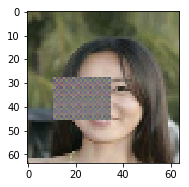

In [ ]:
# Training

args= Parser()        
tf.reset_default_graph()
main_train(args)


In [ ]:
# Testing (Need model)

#tf.reset_default_graph()
#main_test(args)
